In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 380 (delta 122), reused 96 (delta 66), pack-reused 163
Receiving objects: 100% (380/380), 55.90 MiB | 13.43 MiB/s, done.
Resolving deltas: 100% (179/179), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27628 sha256=537d1fe70d7e0cd5fc21df42cfba005dbff3288a871e35a3cdb06680d5410f1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-yxkrba2w/wheels/55/59/29/0fb1c6356521

In [1]:
from dul_2021.utils.hw11_utils import *

In [2]:
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt




import torchvision
from torchvision.datasets import STL10, CIFAR10
from torchvision import transforms

from sklearn.metrics import accuracy_score
from scipy.stats import mannwhitneyu
import numpy as np

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [3]:
class Encoder(nn.Module):
    def __init__(self, in_ch=1, out_dim=128, hid_dim_full=128):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(in_ch, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.conv_to_fc = 7 * 7 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)


    def forward(self, x):
    
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features


class Student(nn.Module):
    def __init__(self, in_ch=1, out_dim=128, hid_dim_full=128):
        super(Student, self).__init__()
        self.f = Encoder(in_ch=in_ch, out_dim=out_dim, hid_dim_full=hid_dim_full)
        self.predictor = nn.Sequential(nn.Linear(out_dim, hid_dim_full),
                                       nn.BatchNorm1d(hid_dim_full), 
                                       nn.ReLU(), 
                                       nn.Linear(hid_dim_full, out_dim))

    def forward(self, x):
        return self.predictor(self.f(x))

class Teacher(nn.Module):
    def __init__(self, in_ch=1, out_dim=128, hid_dim_full=128, tau=0.99):
        super(Teacher, self).__init__()
        self.f = Encoder(in_ch=in_ch, out_dim=out_dim, hid_dim_full=hid_dim_full)
        self.tau = tau
        for p in self.f.parameters():
            p.requires_grad = False

    def update_params(self, f_student, init=False):
        with torch.no_grad():
            for p_teacher, p_student in zip(self.f.parameters(), f_student.parameters()):
                if init:
                    new_val = p_student
                else:
                    new_val  = self.tau * p_teacher  + (1 - self.tau) * p_student

                p_teacher.copy_(new_val)

    def forward(self, x):
        return self.f(x)


class BYOL(nn.Module):
    def __init__(self, in_ch=1, out_dim=128, hid_dim_full=128, tau=0.99):
        super(BYOL, self).__init__()

        self.student = Student(in_ch=in_ch, out_dim=out_dim, hid_dim_full=hid_dim_full)
        self.teacher = Teacher(in_ch=in_ch, out_dim=out_dim, hid_dim_full=hid_dim_full, tau=tau)
        self.teacher.update_params(self.student.f, init=True)


    def loss(self, batch):
        imgs1 = BYOL_transforms(batch).to(device)
        imgs2 = BYOL_transforms(batch).to(device)

        feats_student = self.student(imgs1)
        feats_student = F.normalize(feats_student, dim=1)
        with torch.no_grad():
            feats_teacher = self.teacher(imgs2)
            feats_teacher = F.normalize(feats_teacher, dim=1)
        t1 = 2 - 2 * (feats_student * feats_student).sum(dim=1)

        feats_student = self.student(imgs2)
        feats_student = F.normalize(feats_student, dim=1)
        with torch.no_grad():
            feats_teacher = self.teacher(imgs1)
            feats_teacher = F.normalize(feats_teacher, dim=1)
        t2 = 2 - 2 * (feats_student * feats_student).sum(dim=1)
        
        loss = t1 + t2
        return loss.mean()


    def fit(self, train_data, lr=1e-4, num_epochs=20):
        optim = opt.Adam(self.student.parameters(), lr=lr, weight_decay=1e-4)
        # lr_scheduler = opt.lr_scheduler.CosineAnnealingLR(optim, T_max=num_epochs, eta_min=lr/50)
        trainloader = data.DataLoader(train_data, batch_size=256, shuffle=True)

        losses = []
        for epoch in tqdm(range(num_epochs)):
            for batch in tqdm(trainloader):
                loss = self.loss(batch)
                optim.zero_grad()
                loss.backward()
                optim.step()
                self.teacher.update_params(self.student.f)

                losses.append(loss.item())
                # print(loss.item())
            print(f"[{epoch:2}/{num_epochs}]: loss={np.mean(losses[-len(trainloader):]):.4f}")
            # lr_scheduler.step()

        return np.array(losses)  
        
# def normalize(x):
#     return x / ((x * x).sqrt().sum(dim=1)[:, None] + 1e-8)

In [12]:
BYOL_transforms = transforms.Compose([
                                      transforms.RandomHorizontalFlip(),
                                      # transforms.RandomRotation(degrees=(-30, 30)),
                                      transforms.RandomResizedCrop(size=28),
                                      transforms.GaussianBlur((5, 5), sigma=(0.1, 2)),
                                     ])

In [13]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

    train_data, _ = zip(*train_data)

    model = BYOL()
    model.to(device)
    losses = model.fit(train_data, num_epochs=5)

    def get_latent(x):
        x = x.to(device)
        with torch.no_grad():
            return model.student.f(x).detach().cpu()
    
    return losses, get_latent

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

[ 0/5]: loss=0.0000


  0%|          | 0/235 [00:00<?, ?it/s]

[ 1/5]: loss=0.0000


  0%|          | 0/235 [00:00<?, ?it/s]

[ 2/5]: loss=0.0000


  0%|          | 0/235 [00:00<?, ?it/s]

[ 3/5]: loss=0.0000


  0%|          | 0/235 [00:00<?, ?it/s]

[ 4/5]: loss=0.0000
mean classification accuracy=0.1135


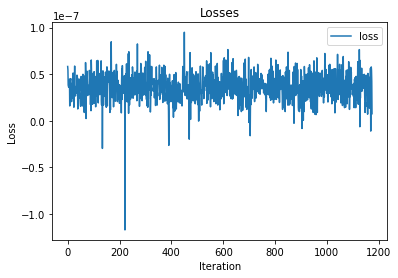

In [6]:
q1_results(q1, True)

странно..

mean classification accuracy=0.6393


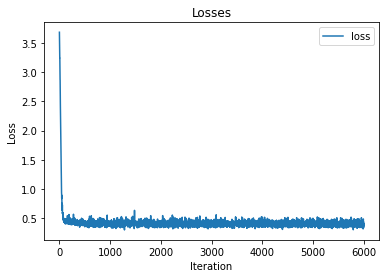

In [ ]:
# ref
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
from torchvision.transforms.transforms import ToPILImage
class Net(nn.Module):
    def __init__(self, in_ch=3, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.conv_to_fc = 8 * 8 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)


    def forward(self, x):
    
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features


class BarlowTwins(nn.Module):
    def __init__(self, in_ch=3, out_dim=128, hid_dim_full=128, lam=0.01):
        super(BarlowTwins, self).__init__()

        self.f = Net(in_ch=in_ch, out_dim=out_dim, hid_dim_full=hid_dim_full)
        self.lam = lam
        self.transforms = transforms.Compose([
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomResizedCrop(size=32)
                                             ])


    def loss(self, batch):
        xA = self.transforms(batch).to(device)
        xB = self.transforms(batch).to(device)

        zA = self.f(xA)
        zB = self.f(xB)

        C = zA.T @ zB

        denomA = (zA * zA).sum(dim=0)[None, :].sqrt()
        denomA = torch.max(torch.stack([denomA, torch.ones(denomA.shape).to(device) * 1e-12], dim=2), dim=2)[0]
        C = C / denomA
        denomB = (zB * zB).sum(dim=0)[:, None].sqrt()
        denomB = torch.max(torch.stack([denomB, torch.ones(denomB.shape).to(device) * 1e-12], dim=2), dim=2)[0]
        C = C / denomB
        t1 = ((1 - C.diag()) ** 2).sum()
        t2 = ((C * (1 - torch.eye(len(C))).to(device)) ** 2).sum()

        return t1 + self.lam * t2


    def fit(self, train_data, lr=5e-4, num_epochs=20):
        optim = opt.AdamW(self.f.parameters(), lr=lr, weight_decay=1e-4)
        # lr_scheduler = opt.lr_scheduler.CosineAnnealingLR(optim, T_max=num_epochs, eta_min=lr/50)
        trainloader = data.DataLoader(train_data, batch_size=256, shuffle=True)

        losses = []
        for epoch in tqdm(range(num_epochs)):
            for batch in tqdm(trainloader):
                loss = self.loss(batch)
                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())
            print(f"[{epoch:2}/{num_epochs}]: loss={np.mean(losses[-len(trainloader):]):.4f}")
            # lr_scheduler.step()

        return losses    

In [ ]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    train_data, _ = zip(*train_data)
    model = BarlowTwins()
    model.to(device)
    losses = model.fit(train_data, num_epochs=20)

    def get_latent(x):
        x = x.to(device)
        with torch.no_grad():
            return model.f(x).detach().cpu()
    
    return losses, get_latent

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

[ 0/20]: loss=23.9472


  0%|          | 0/196 [00:00<?, ?it/s]

[ 1/20]: loss=14.8257


  0%|          | 0/196 [00:00<?, ?it/s]

[ 2/20]: loss=13.0780


  0%|          | 0/196 [00:00<?, ?it/s]

[ 3/20]: loss=12.1584


  0%|          | 0/196 [00:00<?, ?it/s]

[ 4/20]: loss=11.0070


  0%|          | 0/196 [00:00<?, ?it/s]

[ 5/20]: loss=10.8153


  0%|          | 0/196 [00:00<?, ?it/s]

[ 6/20]: loss=10.4611


  0%|          | 0/196 [00:00<?, ?it/s]

[ 7/20]: loss=9.7630


  0%|          | 0/196 [00:00<?, ?it/s]

[ 8/20]: loss=9.7494


  0%|          | 0/196 [00:00<?, ?it/s]

[ 9/20]: loss=9.5653


  0%|          | 0/196 [00:00<?, ?it/s]

[10/20]: loss=9.1312


  0%|          | 0/196 [00:00<?, ?it/s]

[11/20]: loss=9.4782


  0%|          | 0/196 [00:00<?, ?it/s]

[12/20]: loss=9.5725


  0%|          | 0/196 [00:00<?, ?it/s]

[13/20]: loss=10.4750


  0%|          | 0/196 [00:00<?, ?it/s]

[14/20]: loss=9.3709


  0%|          | 0/196 [00:00<?, ?it/s]

[15/20]: loss=8.9408


  0%|          | 0/196 [00:00<?, ?it/s]

[16/20]: loss=9.0488


  0%|          | 0/196 [00:00<?, ?it/s]

[17/20]: loss=8.9095


  0%|          | 0/196 [00:00<?, ?it/s]

[18/20]: loss=8.7039


  0%|          | 0/196 [00:00<?, ?it/s]

[19/20]: loss=8.8348
mean classification accuracy=0.2731


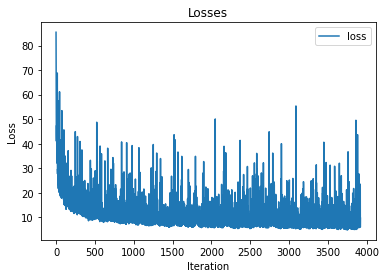

In [ ]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)